# Mapping the seasonal changes to the open water extent of Lake Chad

* **Products used:** 
[ls7_sr](https://explorer.digitalearth.africa/products/ls7_sr), [ls8_sr](https://explorer.digitalearth.africa/products/ls8_sr)



## Background

A couple of very instructive papers on Lake Chad

- [The Lake Chad hydrology under current climate change](https://www.nature.com/articles/s41598-020-62417-w)
- [Recent Surface Water Extent of Lake Chad from Multispectral Sensors and GRACE](https://www.mdpi.com/1424-8220/18/7/2082)

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 


### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import datacube
import matplotlib.pyplot as plt
import numpy as np
import sys
import xarray as xr
import geopandas as gpd

from IPython.display import Image
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from odc.ui import image_aspect
from datacube.utils import geometry, masking
from datacube.utils.cog import write_cog

from deafrica_tools.datahandling import load_ard, wofs_fuser
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import map_shapefile
from deafrica_tools.dask import create_local_dask_cluster
from deafrica_tools.spatial import xr_rasterize, xr_vectorize

from datacube.utils.aws import configure_s3_access
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

## Set up a Dask cluster

Dask can be used to better manage memory use and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/06_Parallel_processing_with_dask.ipynb).

To activate Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

/env/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43863 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:42635 Dashboard: /user/fang.yuan@ga.gov.au/proxy/43863/status,Cluster Workers: 1 Cores: 15 Memory: 104.37 GB


## Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.

The parameters are:
* `vector_file`: The path to the shapefile or geojson that will define the analysis area of the study
* `products`: The products to load from the datacube, e.g. `'s2_l2a``, or `'ls8_sr'`
* `time_range`: The date range to analyse (e.g. `('2017', '2019')`.
* `measurements`: The spectral bands to load from the satellite product. `MNDWI` requires the `'green'` and `'swir_1'` bands
* `resolution`: The pixel resolution of the satellite data. `(-30,30)` for Landsat or `(-10,10)` for Sentinel-2
* `dask_chunks`: Chunk sizes to use for dask, the default values below are optimized for the full Okavango delta

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The default area is the Ruko Conservancy. 


In [3]:
vector_file = 'data/lake_chad_extent.geojson'

product = 'wofs_ls'

collection_category = 'T1'

baseline_time = ('1986-12', '1987-02')
analysis_time = ('2021-12', '2022-02')
resolution = (-30,30)

dask_chunks = {'time':1,'x':1500,'y':1500}


## View the Area of Interest on an interative map
The next cell will  first open the vector file and then display the selected area on an interactive map.
Zoom in and out to get a better understanding of the area of interest.

In [4]:
#read shapefile
gdf = gpd.read_file(vector_file)
gdf['id'] = 1

map_shapefile(gdf, attribute='id')

Label(value='')

Map(center=[13.50116392985322, 14.23553466796875], controls=(ZoomControl(options=['position', 'zoom_in_text', …

### Connect to the datacube

Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [5]:
dc = datacube.Datacube(app='water_extent')

## Load cloud-masked Satellite data

The first step is to load satellite data for the specified area of interest and time range. 

In [6]:
bbox=list(gdf.total_bounds)
lon_range = (bbox[0], bbox[2])
lat_range = (bbox[1], bbox[3])

#create the dc query
baseline_query = {
    'x': lon_range,
    'y': lat_range,
    'time': baseline_time,
    'resolution': resolution,
    'output_crs': 'EPSG:6933',
    'dask_chunks': dask_chunks,
    'group_by':'solar_day'
              }

#create the dc query
analysis_query = {
    'x': lon_range,
    'y': lat_range,
    'time': analysis_time,
    'resolution': resolution,
    'output_crs': 'EPSG:6933',
    'dask_chunks': dask_chunks,
    'group_by':'solar_day'
              }

Now load the satellite data

In [7]:
wofl = dc.load(product=product, fuse_func=wofs_fuser,
                collection_category=collection_category, **baseline_query)
sample_frequency="QS-DEC"  # quarterly starting in DEC, i.e. seasonal

#resample MNDWI using medians
#print('calculating '+wetness_index+' seasonal medians...')
#ds = ds.resample(time='1M', loffset='1M').median().compute()

wet = masking.make_mask(wofl.water, wet=True) 
dry = masking.make_mask(wofl.water, dry=True)
nwet = wet.resample(time=sample_frequency).sum()
ndry = dry.resample(time=sample_frequency).sum()
nobs =nwet+ndry
freq = nwet/nobs

#select use starting month of the quarter/season`
baseline_wofs = freq.to_dataset(name='frequency').compute()

In [8]:
wofl = dc.load(product=product, fuse_func=wofs_fuser,
                collection_category=collection_category, **analysis_query)
sample_frequency="QS-DEC"  # quarterly starting in DEC, i.e. seasonal

#resample MNDWI using medians
#print('calculating '+wetness_index+' seasonal medians...')
#ds = ds.resample(time='1M', loffset='1M').median().compute()

wet = masking.make_mask(wofl.water, wet=True) 
dry = masking.make_mask(wofl.water, dry=True)
nwet = wet.resample(time=sample_frequency).sum()
ndry = dry.resample(time=sample_frequency).sum()
nobs =nwet+ndry
freq = nwet/nobs

#select use starting month of the quarter/season`
analysis_wofs = freq.to_dataset(name='frequency').compute()

In [9]:
#create mask
mask = xr_rasterize(gdf, baseline_wofs)

#mask data
baseline_wofs = baseline_wofs.where(mask)
analysis_wofs = analysis_wofs.where(mask)

In [10]:
#baseline_wofs.frequency.squeeze().plot.imshow();

In [11]:
#analysis_wofs.frequency.squeeze().plot.imshow();

In [12]:
baseline_area=baseline_wofs.frequency>0.2
analysis_area=analysis_wofs.frequency>0.2

## Plotting
Plot water extent of the MNDWI product for the two chosen periods.

### Save the water extents as geotiffs 

Both the 'analysis time' and the 'baseline time' water extents will be saved as cloud-opimtised geotiffs in the `results/` folder

In [13]:
write_cog(baseline_wofs.frequency,
          fname='results/water_extent_'+str(baseline_wofs.time.values.astype('datetime64[M]')[0])+'.tif',
          overwrite=True)

write_cog(analysis_wofs.frequency,
          fname='results/water_extent_'+str(analysis_wofs.time.values.astype('datetime64[M]')[0])+'.tif',
          overwrite=True)

PosixPath('results/water_extent_2021-12.tif')

In [14]:
analysis_area.values

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

### Calculate the change between the two nominated periods

The cells below calculate the amount of water gain, loss and stable for the two periods

In [15]:
pixel_length = baseline_query["resolution"][1]  # in metres
m_per_km = 1000  # conversion from metres to kilometres
area_per_pixel = pixel_length**2 / m_per_km**2

# The two period Extract the two periods(Baseline and analysis) dataset from
analyse_total_area = analysis_area.sum(dim=['x','y']) * area_per_pixel


change = analysis_area*1. - baseline_area.values*1.

water_appeared = change.where(change == 1)
permanent_water = change.where((change == 0) & analysis_area)
permanent_land = change.where((change == 0) & ~analysis_area)
water_disappeared = change.where(change == -1)

The cell below calculate the area of water extent for water_loss, water_gain, permanent water and land 

In [17]:
#total_area = analyse_total_value.count().values * area_per_pixel
water_apperaed_area = water_appeared.count().values * area_per_pixel
permanent_water_area = permanent_water.count().values * area_per_pixel
water_disappeared_area = water_disappeared.count().values * area_per_pixel

In [18]:
water_appeared#.plot.imshow()

<xarray.DataArray 'frequency' (time: 1, y: 8056, x: 8127)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time         (time) datetime64[ns] 2021-12-01
  * y            (y) float64 1.827e+06 1.827e+06 ... 1.586e+06 1.586e+06
  * x            (x) float64 1.252e+06 1.252e+06 ... 1.495e+06 1.495e+06
    spatial_ref  int32 6933

## Plot the changes
The water variables are plotted to visualised the result

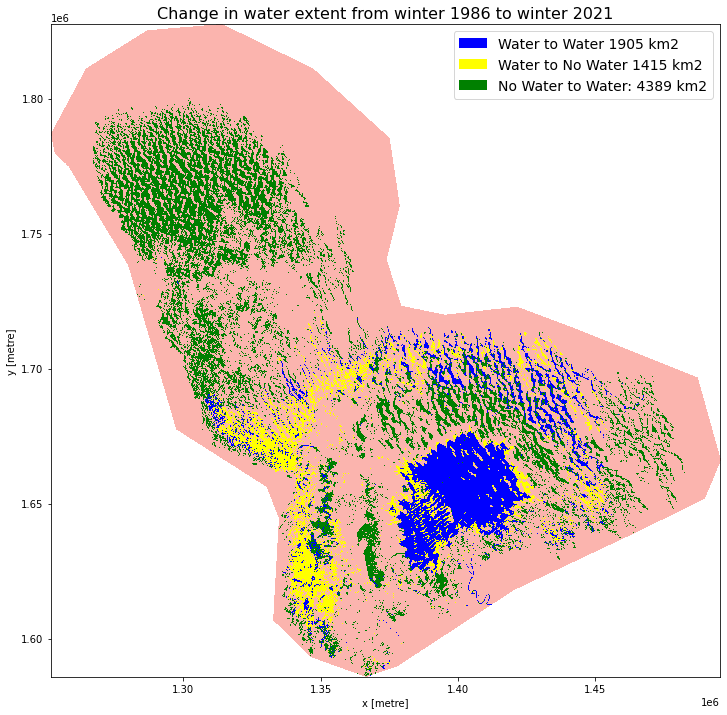

In [21]:
water_appeared_color = "Green"
water_disappeared_color = "Yellow"
stable_color = "Blue"
land_color = "Brown"

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

analysis_area.squeeze().where(mask).plot.imshow(cmap="Pastel1",
                                       add_colorbar=False,
                                       #add_labels=False,
                                       ax=ax)
water_appeared.squeeze().plot.imshow(
    cmap=ListedColormap([water_appeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
water_disappeared.squeeze().plot.imshow(
    cmap=ListedColormap([water_disappeared_color]),
    add_colorbar=False,
    add_labels=False,
    ax=ax,
)
permanent_water.squeeze().plot.imshow(cmap=ListedColormap([stable_color]),
                            add_colorbar=False,
                            add_labels=False,
                            ax=ax)

plt.legend(
    [
        Patch(facecolor=stable_color),
        Patch(facecolor=water_disappeared_color),
        Patch(facecolor=water_appeared_color),
        Patch(facecolor=land_color),
    ],
    [
        f"Water to Water {round(permanent_water_area)} km2",
        f"Water to No Water {round(water_disappeared_area)} km2",
        f"No Water to Water: {round(water_apperaed_area)} km2",
    ],
    loc="upper right", fontsize=14
)

#plt.title("Change in water extent: " + str(baseline_wofs.time.values.astype('datetime64[M]')[0]) + " to " + str(analysis_wofs.time.values.astype('datetime64[M]')[0]));
plt.title("Change in water extent from winter 1986 to winter 2021", fontsize=16);
plt.savefig("results/lake_chad_change_1986-2021_winter.jpg");

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [ ]:
print(datacube.__version__)

**Last Tested:**

In [ ]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')